In [1]:
import pandas as pd

from data_preprocessing import encode_categorical_features, transform_target_to_categorical
from sampling import create_train_test_sets, create_stratified_kfolds

from model_evaluation import evaluate_model
from visualization import plot_tree_based_model, plot_model_accuracy_for_epochs, \
    plot_model_loss_for_epochs, plot_acc_overview, plot_mcc_overview, plot_acc_per_ccp_alpha, plot_correlation_matrix
from feature_selection import exclude_correlated_features, exclude_low_variance_features, \
    select_features_using_information_gain, chi2_feature_selection

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
# notebook parameters
input_dataset_path = 'data/heart.csv'
target_col = 'target'

### Loading dataset

In [3]:
heart_df = pd.read_csv(input_dataset_path)
heart_df[target_col] = heart_df[target_col].astype(int)
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=[target_col]).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df[target_col].unique()}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 1025 rows and 14 colums
Input dataset consists of 13 features and 1 target column
Target values are: [0 1]
Input dataset contains 723 duplicated rows and 302 unique rows


In [5]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int32  
dtypes: float64(1), int32(1), int64(12)
memory usage: 108.2 KB


### Data preprocessing

In [6]:
# delete all duplicated values within the dataset
heart_df.drop_duplicates(inplace=True)

In [7]:
# encode categorical features using LabelEncoder and OneHotEncoding
heart_df = encode_categorical_features(heart_df, target_col)

Ordinal Categorical Features: []
Nominal Categorical Features: []


In [8]:
# divide a heart failure dataset into features and target value sets
x = heart_df.drop(columns=[target_col])
y = heart_df[target_col]

### Data sampling

In [10]:
# Select training and test datasets
x_train, x_test, y_train, y_test = create_train_test_sets(x_df=x, y_df=y, test_size=0.25)

Training dataset consists of 226 records
Test dataset consists of 76 records


In [25]:
# Transform target data sets into binary matrix representation of the target values
y_train_cat = transform_target_to_categorical(target_df=y_train)
y_test_cat = transform_target_to_categorical(target_df=y_test)

### Feature scaling

In [11]:
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.transform(x_test)

# Create DataFrames with scaled features
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)

### Feature selection based on training dataset

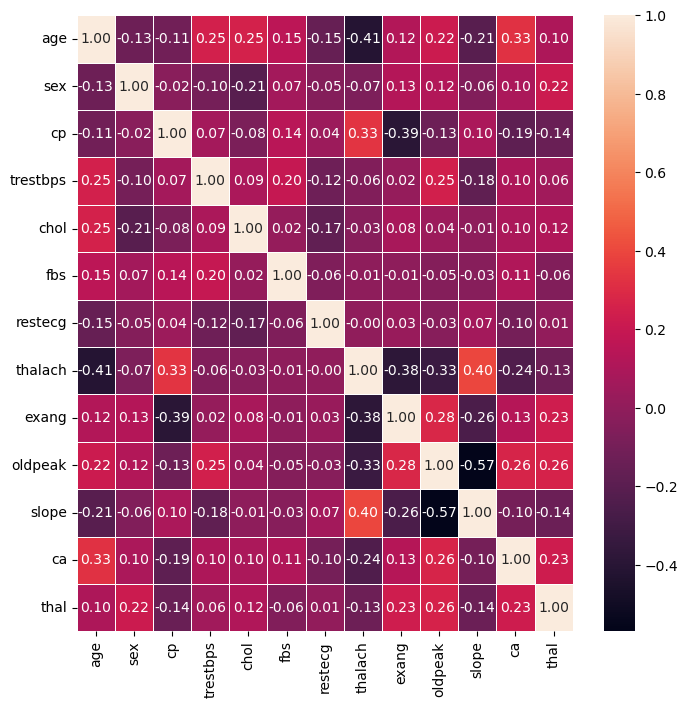

In [12]:
var_thr = VarianceThreshold(0.9)
var_thr.fit(x_train)

const_cols = [column for column in x_train.columns if column not in x_train.columns[var_thr.get_support()]]

if const_cols:
    x_train.drop(columns=const_cols, inplace=True)
    x_test.drop(columns=const_cols, inplace=True)

corr_matrix = plot_correlation_matrix(x_train)
x_train, x_test = exclude_correlated_features(x_train=x_train, 
                                              x_test=x_test, 
                                              corr_matrix=corr_matrix, 
                                              threshold=0.85)

### Decision Tree

Base error test results: TN 23, FP 12, FN 9, TP 32
Precision (PPV): 72.73%
Recall (Sensitivity, TPR): 78.05%
Specificity (TNR): 65.71%
Accuracy: 72.37%
F1-score: 0.75
Matthews Correlation Coefficient (MCC): 0.44
RMSE: 0.53
R Squared: -0.11
ROC AUC Score: 0.718815331010453
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        35
           1       0.73      0.78      0.75        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



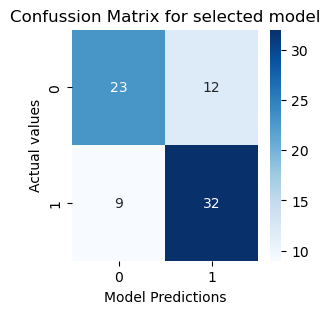

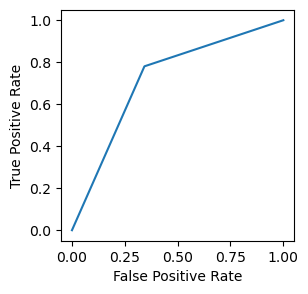

In [13]:
dt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')

dt_model.fit(x_train, y_train)
dt_acc, dt_mcc = evaluate_model(dt_model, x_test=x_test, y_test=y_test)

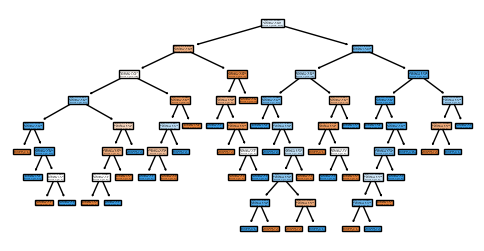

In [14]:
plot_tree_based_model(dt_model)

### Pruning Decision Tree

In [15]:
base_pdt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')
ccp_path = base_pdt_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [16]:
pdt_models = []
for ccp_alpha in ccp_alphas:
    pdt_model = DecisionTreeClassifier(random_state=11,
                                       ccp_alpha=ccp_alpha)
    pdt_model.fit(x_train, y_train)

    # add Pruning Decision Tree classifier to list of trees
    pdt_models.append(pdt_model)

In [17]:
print(f"Last tree in list has {pdt_models[-1].tree_.node_count} node for cpp_alpha parameter {ccp_alphas[-1]}")

Last tree in list has 1 node for cpp_alpha parameter 0.21982887346468272


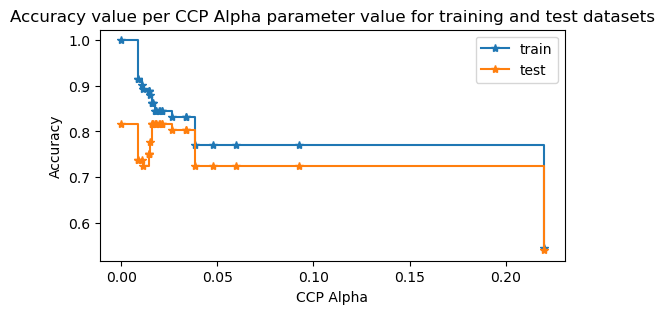

In [18]:
train_scores = [tree.score(x_train, y_train) for tree in pdt_models]
test_scores = [tree.score(x_test, y_test) for tree in pdt_models]

plot_acc_per_ccp_alpha(ccp_alphas, train_scores, test_scores)

Base error test results: TN 26, FP 9, FN 10, TP 31
Precision (PPV): 77.5%
Recall (Sensitivity, TPR): 75.61%
Specificity (TNR): 74.29%
Accuracy: 75.0%
F1-score: 0.77
Matthews Correlation Coefficient (MCC): 0.5
RMSE: 0.5
R Squared: -0.01
ROC AUC Score: 0.7494773519163763
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        35
           1       0.78      0.76      0.77        41

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76



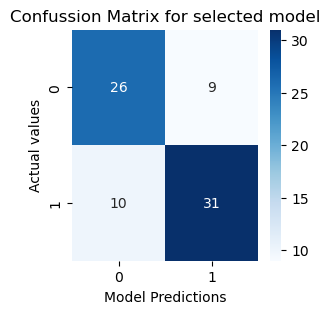

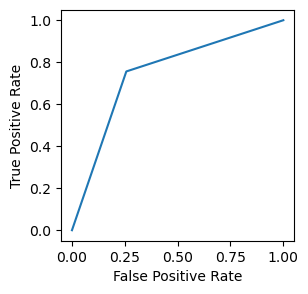

In [19]:
pdt_model = DecisionTreeClassifier(random_state=11,
                             ccp_alpha=0.02, 
                             criterion='entropy')
pdt_model.fit(x_train,y_train)
pdt_acc, pdt_mcc = evaluate_model(pdt_model, x_test=x_test, y_test=y_test)

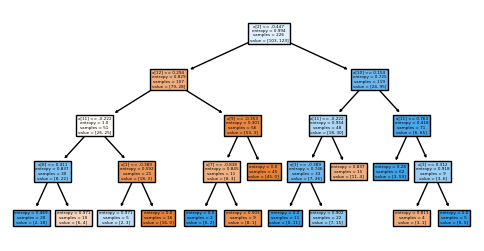

In [20]:
plot_tree_based_model(pdt_model)

### Random Forest

In [21]:
rf_base_model = RandomForestClassifier(random_state=0)
n_estimators = [10, 25, 50, 100, 250]
max_depth = [3, 5, 8, 10, 15]
max_features = ["sqrt", "log2", None, 0.5]
params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features
}

gsearch = GridSearchCV(rf_base_model,
                       param_grid=params,
                       scoring='recall')
gsearch.fit(x_train, y_train)
print(f'The best score is : {gsearch.best_score_}')
print(f'The best estimator is : {gsearch.best_estimator_}')
print(f'The best parameters is : {gsearch.best_params_}')

The best score is : 0.8793333333333333
The best estimator is : RandomForestClassifier(max_depth=3, n_estimators=25, random_state=0)
The best parameters is : {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 25}


Base error test results: TN 27, FP 8, FN 5, TP 36
Precision (PPV): 81.82%
Recall (Sensitivity, TPR): 87.8%
Specificity (TNR): 77.14%
Accuracy: 82.89%
F1-score: 0.85
Matthews Correlation Coefficient (MCC): 0.66
RMSE: 0.41
R Squared: 0.31
ROC AUC Score: 0.8247386759581882
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.84      0.77      0.81        35
           1       0.82      0.88      0.85        41

    accuracy                           0.83        76
   macro avg       0.83      0.82      0.83        76
weighted avg       0.83      0.83      0.83        76



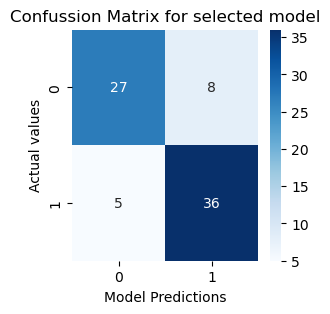

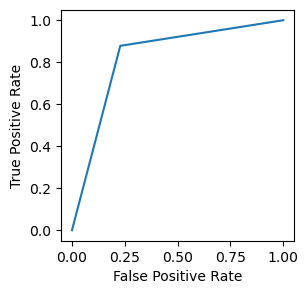

In [22]:
rf_model = RandomForestClassifier(n_estimators=25,
                                  max_features='sqrt',
                                  random_state=0,
                                  max_depth=3)

rf_model.fit(x_train, y_train)
rf_acc, rf_mcc = evaluate_model(rf_model, x_test=x_test, y_test=y_test)

### CNN model

In [23]:
cnn_model = Sequential()
cnn_model.add(Dense(256, 
                    input_dim=13, 
                    activation='relu'))
cnn_model.add(Dense(256, 
                    activation='relu'))
cnn_model.add(Dense(2, 
                    activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(f"CNN model summary: \n{cnn_model.summary()}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69890 (273.01 KB)
Trainable params: 69890 (273.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CNN model summary: 
None


In [26]:
cnn_model.fit(x_train, 
              y_train_cat, 
              epochs=10, 
              validation_data=(x_test, y_test_cat))

Epoch 1/10
8/8 [==============================] - 1s 34ms/step - loss: 0.5436 - accuracy: 0.7478 - val_loss: 0.4405 - val_accuracy: 0.8421
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.3769 - accuracy: 0.8584 - val_loss: 0.4050 - val_accuracy: 0.8421
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.3354 - accuracy: 0.8584 - val_loss: 0.3846 - val_accuracy: 0.8553
Epoch 4/10
8/8 [==============================] - 0s 8ms/step - loss: 0.2995 - accuracy: 0.8850 - val_loss: 0.3869 - val_accuracy: 0.8684
Epoch 5/10
8/8 [==============================] - 0s 8ms/step - loss: 0.3090 - accuracy: 0.8894 - val_loss: 0.3991 - val_accuracy: 0.8553
Epoch 6/10
8/8 [==============================] - 0s 7ms/step - loss: 0.2871 - accuracy: 0.8761 - val_loss: 0.4214 - val_accuracy: 0.8421
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 0.2750 - accuracy: 0.8805 - val_loss: 0.4299 - val_accuracy: 0.8421
Epoch 8/10
8/8 [=================

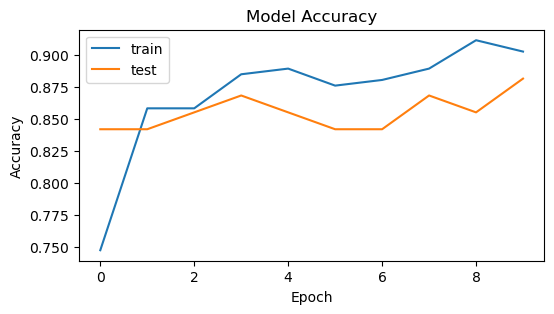

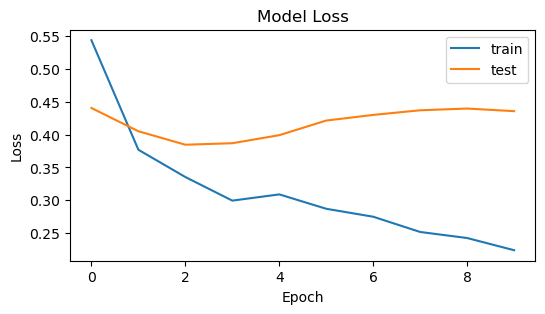

In [27]:
plot_model_accuracy_for_epochs(cnn_model)
plot_model_loss_for_epochs(cnn_model)

In [28]:
print(f"CNN model evaluation after training: {cnn_model.evaluate(x_train, y_train_cat)}")
print (f"CNN model evaluation for test dataset: {cnn_model.evaluate(x_test, y_test_cat)}")

NameError: name 'y_cat_train' is not defined

3/3 [==============================] - 0s 2ms/step
Base error test results: TN 30, FP 5, FN 4, TP 37
Precision (PPV): 88.1%
Recall (Sensitivity, TPR): 90.24%
Specificity (TNR): 85.71%
Accuracy: 88.16%
F1-score: 0.89
Matthews Correlation Coefficient (MCC): 0.76
RMSE: 0.34
R Squared: 0.52
ROC AUC Score: 0.8797909407665506
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        35
           1       0.88      0.90      0.89        41

    accuracy                           0.88        76
   macro avg       0.88      0.88      0.88        76
weighted avg       0.88      0.88      0.88        76



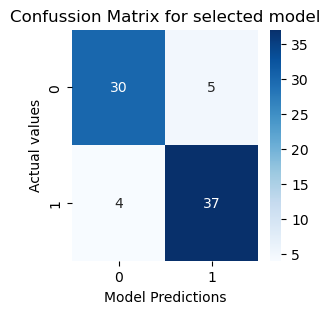

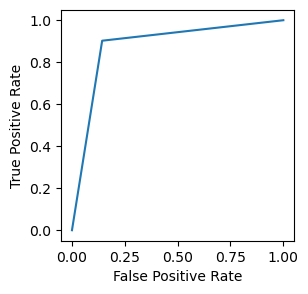

In [29]:
cnn_acc, cnn_mcc = evaluate_model(cnn_model, x_test=x_test, y_test=y_test, is_cnn=True)

### Logistic Regression

Base error test results: TN 27, FP 8, FN 3, TP 38
Precision (PPV): 82.61%
Recall (Sensitivity, TPR): 92.68%
Specificity (TNR): 77.14%
Accuracy: 85.53%
F1-score: 0.87
Matthews Correlation Coefficient (MCC): 0.71
RMSE: 0.38
R Squared: 0.42
ROC AUC Score: 0.8491289198606271
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.83      0.93      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



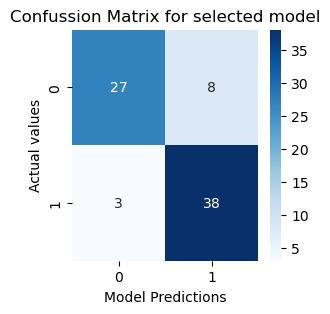

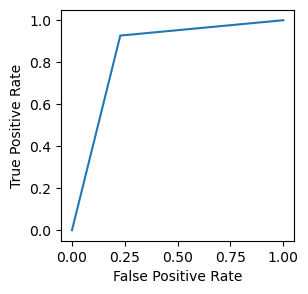

In [30]:
lr_model = LogisticRegression(random_state=0, C=10, penalty='l2')
lr_model.fit(x_train, y_train)
lr_acc, lr_mcc = evaluate_model(lr_model, x_test=x_test, y_test=y_test)

### Support Vector Machine

Base error test results: TN 27, FP 8, FN 2, TP 39
Precision (PPV): 82.98%
Recall (Sensitivity, TPR): 95.12%
Specificity (TNR): 77.14%
Accuracy: 86.84%
F1-score: 0.89
Matthews Correlation Coefficient (MCC): 0.74
RMSE: 0.36
R Squared: 0.47
ROC AUC Score: 0.8613240418118467
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        35
           1       0.83      0.95      0.89        41

    accuracy                           0.87        76
   macro avg       0.88      0.86      0.87        76
weighted avg       0.88      0.87      0.87        76



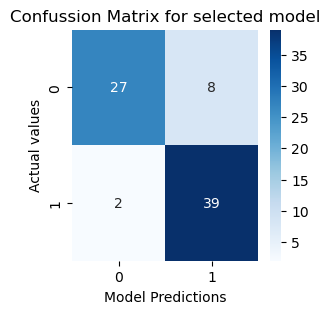

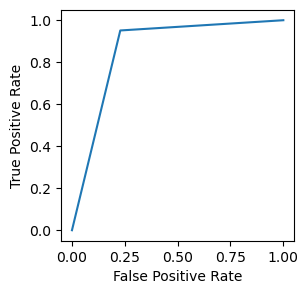

In [31]:
svm_model = SVC(kernel='linear', C=0.3)
svm_model.fit(x_train, y_train)
svm_acc, svm_mcc = evaluate_model(svm_model, x_test=x_test, y_test=y_test)

### K Nearest Neighbours

Base error test results: TN 28, FP 7, FN 5, TP 36
Precision (PPV): 83.72%
Recall (Sensitivity, TPR): 87.8%
Specificity (TNR): 80.0%
Accuracy: 84.21%
F1-score: 0.86
Matthews Correlation Coefficient (MCC): 0.68
RMSE: 0.4
R Squared: 0.36
ROC AUC Score: 0.8390243902439024
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



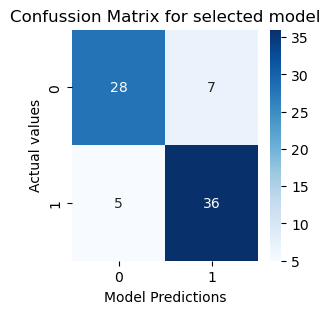

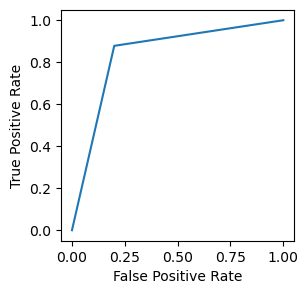

In [32]:
knn_model = KNeighborsClassifier(leaf_size=1, n_neighbors=3)
knn_model.fit(x_train, y_train)
knn_acc, knn_mcc = evaluate_model(knn_model, x_test=x_test, y_test=y_test)

### Gaussian Naive Bayes

Base error test results: TN 26, FP 9, FN 5, TP 36
Precision (PPV): 80.0%
Recall (Sensitivity, TPR): 87.8%
Specificity (TNR): 74.29%
Accuracy: 81.58%
F1-score: 0.84
Matthews Correlation Coefficient (MCC): 0.63
RMSE: 0.43
R Squared: 0.26
ROC AUC Score: 0.8104529616724738
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        35
           1       0.80      0.88      0.84        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.81        76



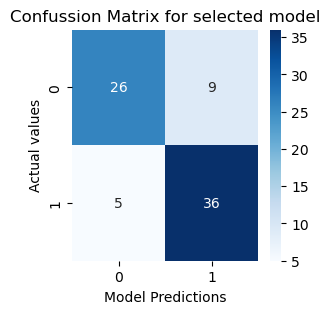

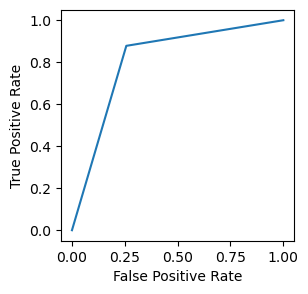

In [33]:
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)
gnb_acc, gnb_mcc = evaluate_model(gnb_model, x_test=x_test, y_test=y_test)

### XGBoost Classifier

Base error test results: TN 27, FP 8, FN 10, TP 31
Precision (PPV): 79.49%
Recall (Sensitivity, TPR): 75.61%
Specificity (TNR): 77.14%
Accuracy: 76.32%
F1-score: 0.77
Matthews Correlation Coefficient (MCC): 0.53
RMSE: 0.49
R Squared: 0.05
ROC AUC Score: 0.7637630662020907
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        35
           1       0.79      0.76      0.77        41

    accuracy                           0.76        76
   macro avg       0.76      0.76      0.76        76
weighted avg       0.76      0.76      0.76        76



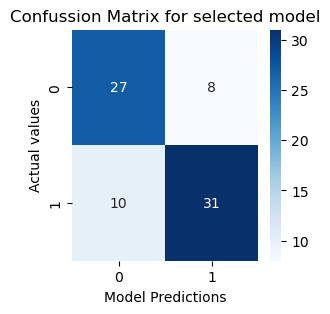

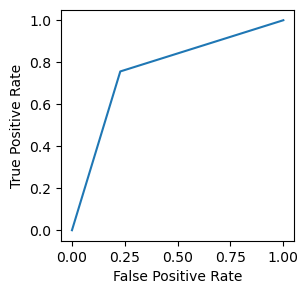

In [34]:
xgb_model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
xgb_model.fit(x_train, y_train)
xgb_acc, xgb_mcc = evaluate_model(xgb_model, x_test=x_test, y_test=y_test)

### CatBoost Classifier

Base error test results: TN 28, FP 7, FN 5, TP 36
Precision (PPV): 83.72%
Recall (Sensitivity, TPR): 87.8%
Specificity (TNR): 80.0%
Accuracy: 84.21%
F1-score: 0.86
Matthews Correlation Coefficient (MCC): 0.68
RMSE: 0.4
R Squared: 0.36
ROC AUC Score: 0.8390243902439024
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



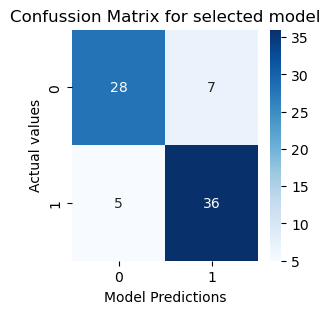

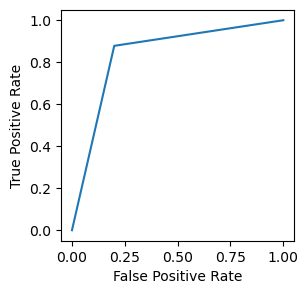

In [35]:
cb_model = CatBoostClassifier(verbose=False)
cb_model.fit(x_train, y_train)
cb_acc, cb_mcc = evaluate_model(cb_model, x_test=x_test, y_test=y_test)

### LightGBM Classifier

In [36]:
# lgbm_model = LGBMClassifier()
# lgbm_model.fit(x_train, y_train)
# lgbm_acc, lgb,_mcc = evaluate_model(lgbm_model, x_test=x_test, y_test=y_test)

### Comparison of models' results

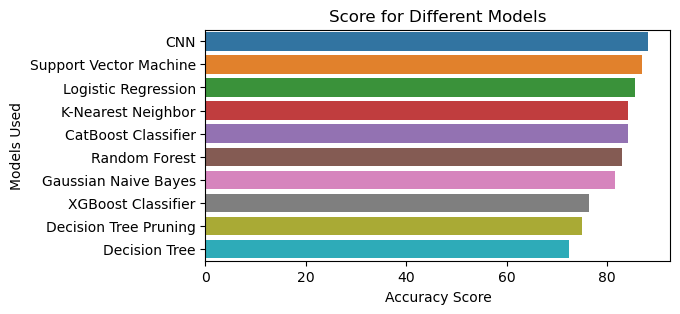

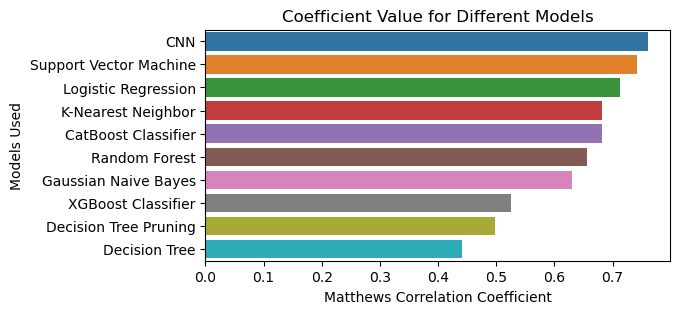

In [37]:
acc_scores = {
    'Decision Tree': dt_acc * 100, 
    'Decision Tree Pruning': pdt_acc * 100, 
    'Random Forest': rf_acc * 100, 
    'Logistic Regression': lr_acc * 100,
    'Support Vector Machine': svm_acc * 100, 
    'K-Nearest Neighbor': knn_acc * 100,
    'CNN': cnn_acc * 100,
    'Gaussian Naive Bayes': gnb_acc * 100,
    'XGBoost Classifier': xgb_acc * 100,
    'CatBoost Classifier': cb_acc * 100
}

mcc_scores = {
    'Decision Tree': dt_mcc, 
    'Decision Tree Pruning': pdt_mcc, 
    'Random Forest': rf_mcc, 
    'Logistic Regression': lr_mcc,
    'Support Vector Machine': svm_mcc, 
    'K-Nearest Neighbor': knn_mcc,
    'CNN': cnn_mcc,
    'Gaussian Naive Bayes': gnb_mcc,
    'XGBoost Classifier': xgb_mcc,
    'CatBoost Classifier': cb_mcc
}

plot_acc_overview(acc_scores)
plot_mcc_overview(mcc_scores)